--- Analyzing Dataset: IMDB-MULTI ---

1. Class Distribution:
1    0.333333
2    0.333333
3    0.333333
Name: proportion, dtype: float64
   - Relation 1: 1.00


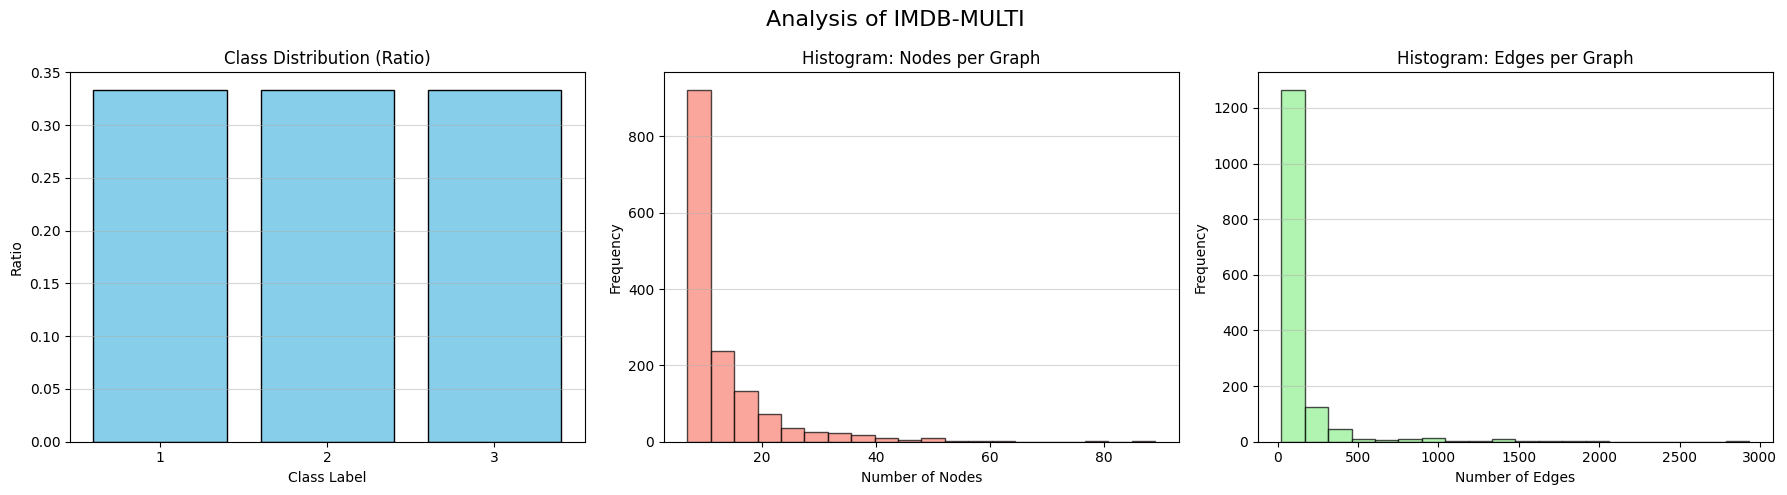

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_dataset(dataset_name):
    # --- Configuration ---
    base_path = os.path.join(os.getcwd(), dataset_name)
    prefix = dataset_name
    
    print(f"--- Analyzing Dataset: {dataset_name} ---")

    # --- File Paths ---
    path_A = os.path.join(base_path, f"{prefix}_A.txt")
    path_indicator = os.path.join(base_path, f"{prefix}_graph_indicator.txt")
    path_labels = os.path.join(base_path, f"{prefix}_graph_labels.txt")

    # --- Check files exist ---
    if not all(os.path.exists(p) for p in [path_A, path_indicator, path_labels]):
        print(f"Error: Could not find one or more files in {base_path}")
        return

    # --- Load Data ---
    # 1. Graph Indicator: Maps Node_ID -> Graph_ID
    # (Reads as a column vector)
    try:
        node_to_graph_id = np.loadtxt(path_indicator, delimiter=',', dtype=int)
    except:
        # Fallback if delimiter is space
        node_to_graph_id = np.loadtxt(path_indicator, dtype=int)

    # 2. Graph Labels: The class of each graph
    try:
        graph_labels = np.loadtxt(path_labels, delimiter=',', dtype=int)
    except:
        graph_labels = np.loadtxt(path_labels, dtype=int)

    # 3. Adjacency Matrix (Edges)
    # Format: row, col (Node IDs). Usually 1-based indexing in these files.
    try:
        adj = np.loadtxt(path_A, delimiter=',', dtype=int)
    except:
        adj = np.loadtxt(path_A, dtype=int)

    # --- Analysis ---

    # 1. Class Distribution
    # Convert to Series to easily calculate ratios
    label_series = pd.Series(graph_labels)
    class_counts = label_series.value_counts().sort_index()
    class_ratios = label_series.value_counts(normalize=True).sort_index()
    
    print("\n1. Class Distribution:")
    print(class_ratios)
    lowest_class = class_ratios.idxmin()
    highest_class = class_ratios.idxmax()
    relation = class_ratios[highest_class] / class_ratios[lowest_class]
    print(f"   - Relation 1: {relation:.2f}")
    # 2. Nodes per Graph
    # We count how many times each Graph ID appears in the indicator file
    # Ensure all graph IDs are represented (even if they have 0 nodes, though unlikely)
    unique_graphs, node_counts = np.unique(node_to_graph_id, return_counts=True)
    
    # 3. Edges per Graph
    # The Adjacency file uses Node IDs. We need to map these Node IDs to Graph IDs.
    # Note: DS_A.txt is usually 1-based index. Python is 0-based.
    # We take the first column (source node), subtract 1 to get index, 
    # then look up which graph that node belongs to.
    source_nodes_0_indexed = adj[:, 0] - 1
    
    # Map every edge to a graph ID
    try:
        edge_graph_ids = node_to_graph_id[source_nodes_0_indexed]
    except IndexError:
        print("Warning: Index mismatch. Ensuring A.txt uses 1-based indexing compatible with indicator file size.")
        # Fallback logic if needed, but usually TUDatasets are consistent
        return

    # Count edges per graph
    # We use pandas to ensure graphs with 0 edges are handled if we merge later, 
    # but for now np.unique on existing edges is sufficient for the histogram
    _, edge_counts = np.unique(edge_graph_ids, return_counts=True)
    
    # Adjust for undirected double-counting if necessary. 
    # Standard TUDatasets list (u,v) and (v,u). 
    # If you want "number of edges" strictly, usually divide by 2 for undirected.
    # Here we plot the "number of entries in A" per graph (degree sum). 
    # To get actual edges for undirected graphs, divide by 2.
    edge_counts = edge_counts / 2 

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Analysis of {dataset_name}', fontsize=16)

    # Plot 1: Class Distribution
    axes[0].bar(class_ratios.index.astype(str), class_ratios.values, color='skyblue', edgecolor='black')
    axes[0].set_title("Class Distribution (Ratio)")
    axes[0].set_xlabel("Class Label")
    axes[0].set_ylabel("Ratio")
    axes[0].grid(axis='y', alpha=0.5)

    # Plot 2: Histogram of Nodes per Graph
    axes[1].hist(node_counts, bins=20, color='salmon', edgecolor='black', alpha=0.7)
    axes[1].set_title("Histogram: Nodes per Graph")
    axes[1].set_xlabel("Number of Nodes")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(axis='y', alpha=0.5)

    # Plot 3: Histogram of Edges per Graph
    axes[2].hist(edge_counts, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[2].set_title("Histogram: Edges per Graph")
    axes[2].set_xlabel("Number of Edges")
    axes[2].set_ylabel("Frequency")
    axes[2].grid(axis='y', alpha=0.5)

    plt.tight_layout()
    plt.show()

# --- ENTRY POINT ---
if __name__ == "__main__":
    # You can change this manually or ask for input
    target_ds = "IMDB-MULTI"
    analyze_dataset(target_ds)